# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[0,-2,3],
              [-1, 2, 0.1]
              ])

testLayer = ReLULayer()

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
from model import TwoLayerNet
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)

#Now implement regularizaion
model.compute_loss_and_gradients(train_X[:2], train_y[:2])



2.2537337939200146

In [7]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for hidden_W parameter
Gradient check passed!
Checking gradient for hidden_B parameter
Gradient check passed!
Checking gradient for output_W parameter
Gradient check passed!
Checking gradient for output_B parameter
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [8]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for hidden_W parameter
Gradient check passed!
Checking gradient for hidden_B parameter
Gradient check passed!
Checking gradient for output_W parameter
Gradient check passed!
Checking gradient for output_B parameter
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [9]:
# Finally, implement predict function!
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [10]:
from trainer import Trainer, Dataset
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(),num_epochs=20, learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 5.329251, Train accuracy: 0.240556, val accuracy: 0.237000
Epoch: 1, Loss: 5.333040, Train accuracy: 0.285222, val accuracy: 0.286000
Epoch: 2, Loss: 4.935654, Train accuracy: 0.317778, val accuracy: 0.310000
Epoch: 3, Loss: 5.105554, Train accuracy: 0.346556, val accuracy: 0.333000
Epoch: 4, Loss: 4.659118, Train accuracy: 0.366667, val accuracy: 0.355000
Epoch: 5, Loss: 4.924880, Train accuracy: 0.382333, val accuracy: 0.375000
Epoch: 6, Loss: 4.635313, Train accuracy: 0.393222, val accuracy: 0.392000
Epoch: 7, Loss: 4.838899, Train accuracy: 0.407889, val accuracy: 0.402000
Epoch: 8, Loss: 4.586705, Train accuracy: 0.412444, val accuracy: 0.414000
Epoch: 9, Loss: 4.005312, Train accuracy: 0.421000, val accuracy: 0.418000
Epoch: 10, Loss: 4.103477, Train accuracy: 0.426000, val accuracy: 0.426000
Epoch: 11, Loss: 4.391783, Train accuracy: 0.429889, val accuracy: 0.422000
Epoch: 12, Loss: 4.141169, Train accuracy: 0.442667, val accuracy: 0.437000
Epoch: 13, Loss: 4.015

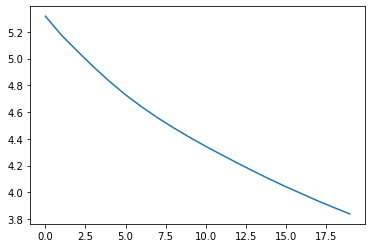

In [11]:
plt.plot(loss_history)

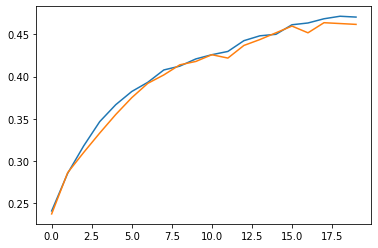

In [12]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [13]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 0, Loss: 53.070348, Train accuracy: 0.195667, val accuracy: 0.205000
Epoch: 1, Loss: 10.759354, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, Loss: 3.768708, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, Loss: 2.507835, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, Loss: 2.267025, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, Loss: 2.327494, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, Loss: 2.277025, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, Loss: 2.305110, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, Loss: 2.269907, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, Loss: 2.343462, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, Loss: 2.278349, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, Loss: 2.228865, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, Loss: 2.296438, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, Loss: 2.2

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [14]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.285799, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, Loss: 2.305556, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, Loss: 2.169268, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, Loss: 2.227925, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, Loss: 2.289553, Train accuracy: 0.148222, val accuracy: 0.140000
Epoch: 5, Loss: 2.289078, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, Loss: 2.236745, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, Loss: 2.312481, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, Loss: 2.269613, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, Loss: 2.225542, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, Loss: 2.308375, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, Loss: 2.304153, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, Loss: 2.293727, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, Loss: 2.256

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [15]:
dataset.train_y

array([9, 9, 2, ..., 4, 2, 7], dtype=uint8)

In [16]:
model.predict(dataset.train_X)

array([3, 2, 2, ..., 3, 2, 3])

In [17]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-7)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=2.8e-2, num_epochs=50, batch_size=15)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.656823, Train accuracy: 0.000000, val accuracy: 0.133333
Epoch: 1, Loss: 2.516913, Train accuracy: 0.133333, val accuracy: 0.066667
Epoch: 2, Loss: 2.252700, Train accuracy: 0.333333, val accuracy: 0.066667
Epoch: 3, Loss: 2.010264, Train accuracy: 0.333333, val accuracy: 0.000000
Epoch: 4, Loss: 1.878531, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 5, Loss: 1.806800, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 6, Loss: 1.735520, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 7, Loss: 1.649465, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch: 8, Loss: 1.558893, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch: 9, Loss: 1.474613, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch: 10, Loss: 1.416436, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch: 11, Loss: 1.382035, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch: 12, Loss: 1.353556, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch: 13, Loss: 1.320

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [18]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=4e-1, num_epochs=20, batch_size=15)

loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 33.281668, Train accuracy: 0.333333, val accuracy: 0.133333
Epoch: 1, Loss: 32.254864, Train accuracy: 0.466667, val accuracy: 0.066667
Epoch: 2, Loss: 31.048355, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch: 3, Loss: 29.601322, Train accuracy: 0.600000, val accuracy: 0.066667
Epoch: 4, Loss: 27.853773, Train accuracy: 0.600000, val accuracy: 0.066667
Epoch: 5, Loss: 26.029445, Train accuracy: 0.666667, val accuracy: 0.000000
Epoch: 6, Loss: 24.034714, Train accuracy: 0.666667, val accuracy: 0.000000
Epoch: 7, Loss: 21.975017, Train accuracy: 0.733333, val accuracy: 0.066667
Epoch: 8, Loss: 19.848111, Train accuracy: 0.733333, val accuracy: 0.200000
Epoch: 9, Loss: 17.860928, Train accuracy: 0.733333, val accuracy: 0.200000
Epoch: 10, Loss: 15.983105, Train accuracy: 0.733333, val accuracy: 0.200000
Epoch: 11, Loss: 14.131378, Train accuracy: 0.733333, val accuracy: 0.133333
Epoch: 12, Loss: 12.402425, Train accuracy: 0.733333, val accuracy: 0.066667
Epoch: 13

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [20]:
# Let's train the best one-hidden-layer network we can

learning_rate = 1e-2
reg_strength = 1e-3
learning_rate_decay = 0.995
hidden_layer_size = 128
num_epochs = 100
batch_size = 64

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, 
                  dataset, MomentumSGD(), 
                  learning_rate=learning_rate,
                  num_epochs=num_epochs, 
                  batch_size=batch_size, 
                  learning_rate_decay=learning_rate_decay
                 )

loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 5.801769, Train accuracy: 0.262889, val accuracy: 0.264000
Epoch: 1, Loss: 5.579680, Train accuracy: 0.326444, val accuracy: 0.312000
Epoch: 2, Loss: 5.011766, Train accuracy: 0.377556, val accuracy: 0.381000
Epoch: 3, Loss: 4.612413, Train accuracy: 0.430556, val accuracy: 0.415000
Epoch: 4, Loss: 4.400833, Train accuracy: 0.481667, val accuracy: 0.463000
Epoch: 5, Loss: 4.342537, Train accuracy: 0.521667, val accuracy: 0.508000
Epoch: 6, Loss: 4.236347, Train accuracy: 0.566333, val accuracy: 0.566000
Epoch: 7, Loss: 3.756008, Train accuracy: 0.592556, val accuracy: 0.577000
Epoch: 8, Loss: 3.937789, Train accuracy: 0.605444, val accuracy: 0.601000
Epoch: 9, Loss: 3.645066, Train accuracy: 0.625667, val accuracy: 0.605000
Epoch: 10, Loss: 3.282560, Train accuracy: 0.632111, val accuracy: 0.627000
Epoch: 11, Loss: 3.248752, Train accuracy: 0.644111, val accuracy: 0.635000
Epoch: 12, Loss: 3.327053, Train accuracy: 0.652444, val accuracy: 0.628000
Epoch: 13, Loss: 3.223

In [21]:
best_classifier = model
best_loss_history = loss_history
best_train_history = train_history
best_val_history = val_history


In [ ]:
plt.plot(best_loss_history)

# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [22]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.744000
